# Sentiment Analysis on small amount of data

In [1]:
import os
import pandas as pd
from tqdm import tqdm_notebook as tqdm

## Read Comments

The data is scattered in .txt files all over the positive and the negative directory.  
Therefore, we would **read all the .txt files** and **assign labels** to them.   
Finally, **save to a Pandas DataFrame** for convenience.

### Dataset -- Booking.com comments

In [2]:
# Read comments in the directory
def read_dir(directory):
    directory
    content_list = []
    files = os.listdir(directory)
    for file in tqdm(files):
        with open(os.path.join(directory, file), 'r', encoding='utf8') as f:
            content_list.append(f.read().strip())
    return content_list
            

positives = read_dir('./dataset/CrawlerToBooking/positiveReviews/')
negatives = read_dir('./dataset/CrawlerToBooking/negativeReviews/')

# Add label on data and Transfer to Dataframe for convenience
booking_dataset = pd.DataFrame({'TEXT': positives + negatives, 
                               'SENTI': [1]*len(positives) + [0]*len(negatives)})

## Save as a CSV File

Because the **line break** will lead the unexpected newline in .csv file.  
We deal with this problem by **substitute a blank** for each one

In [7]:
import re

# Substitute blank for line break
def sub_newline(x): return re.sub('\\n', ' ', x)
print('Before: %s \nAfter: %s' % (booking_dataset.TEXT[0], sub_newline(booking_dataset.TEXT[0])))

Before: 乾淨不受打擾。
沒有櫃台人員是十分信認顧客的地方，雖然或許少了點噓寒問暖的親切，卻也多了一份不受監視的自在感。 
After: 乾淨不受打擾。 沒有櫃台人員是十分信認顧客的地方，雖然或許少了點噓寒問暖的親切，卻也多了一份不受監視的自在感。


In [8]:
# Remove line break to avoid wrong in .csv file
booking_dataset['TEXT'] = booking_dataset['TEXT'].map(sub_newline)
booking_dataset.to_csv('./dataset/booking.csv', index=False, encoding='utf8')

# Display
booking_dataset.head(5)

,TEXT,SENTI
0,乾淨不受打擾。 沒有櫃台人員是十分信認顧客的地方，雖然或許少了點噓寒問暖的親切，卻也多了一份...,1
1,環境整潔乾淨 管家親切,1
2,位置很好，旁邊就是早市，早上很熱鬧且有許多好吃的早餐在附近。,1
3,喜歡整棟樓的香味包括房間...房間的舒適度真的很好會讓人想再進去關顧！,1
4,路邊就可以停車，住起來還算不錯~價格也不貴~,1


## Read CSV File

Read the .csv file to a Dataframe.  
Pandas would regard a comment **composed of only numbers** as **float-type**.  
Hence, we need to transfer it into **string-type** manually.

In [9]:
booking_dataset = pd.read_csv('./dataset/booking.csv', encoding='utf8')
booking_dataset['TEXT'] = booking_dataset['TEXT'].map(str)

## Analysis Data

Briefly check **the lengths** of most of the comments.  
Find a suitable split point to apply BERT model. 

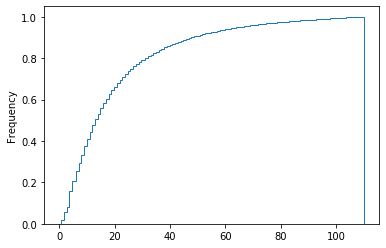

count    341722.000000
mean         24.391110
std          35.348509
min           1.000000
25%           7.000000
50%          14.000000
75%          28.000000
max        1973.000000
Name: TEXT, dtype: float64

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

text_len = booking_dataset['TEXT'].map(len)
text_len.plot.hist(bins=300, density=True, cumulative=True, histtype='step', range=(0, 110))
plt.show()

text_len.describe()

Print the cumulative percentage at 80%, 85%, 90%, 92%, and 95%.  

In [11]:
max_len = text_len.max()

len_sum = [0] * max_len
for i in text_len:
    len_sum[i-1] += 1
    
len_cum = [len_sum[0]] + [0] * (max_len-1)
for i in range(1, max_len):
    len_cum[i] += len_sum[i] + len_cum[i-1]

print('Cumulative %   # Words  # Comments')
for i in range(max_len):
    len_cum[i] /= len(text_len)
    if len_sum[i] != 0:
        if (len_cum[i] >= 0.8 and len_cum[i-1] < 0.8):
            print(' %.5f   \t  %d \t    %d'%(len_cum[i]*100, i, len_sum[i]))
        if (len_cum[i] >= 0.85 and len_cum[i-1] < 0.85):
            print(' %.5f   \t  %d \t    %d'%(len_cum[i]*100, i, len_sum[i]))
        if (len_cum[i] >= 0.9 and len_cum[i-1] < 0.9):
            print(' %.5f   \t  %d \t    %d'%(len_cum[i]*100, i, len_sum[i]))
        if (len_cum[i] >= 0.92 and len_cum[i-1] < 0.92):
            print(' %.5f   \t  %d \t    %d'%(len_cum[i]*100, i, len_sum[i]))
        if (len_cum[i] >= 0.95 and len_cum[i-1] < 0.95):
            print(' %.5f   \t  %d \t    %d'%(len_cum[i]*100, i, len_sum[i]))

Cumulative %   # Words  # Comments
 80.35245   	  33 	    2582
 85.27370   	  41 	    1808
 90.22685   	  54 	    1020
 92.17727   	  62 	    739
 95.04656   	  80 	    419


We finally choose **60** as the Max Length. (≒ 91%)

## Preprocess

1. Data cleaning
2. Remove too long comments
3. Sampling training (2%) / testing (10%) / validation set (10%)
4. Save to .csv file

In [15]:
# Data cleaning -- Remove some empty comments.
empty = ((booking_dataset['TEXT'].isnull()) | \
         (booking_dataset['TEXT'] == '')    | \
         (booking_dataset['TEXT'] == '0')   | \
         (booking_dataset['TEXT'].map(len) == 0))
train_set = booking_dataset[~empty]

# Exclude the comments too long to avoid the whole sequence encoding by BERT out of GPU memory
MAX_LENGTH = 60
train_set = train_set[~(train_set.TEXT.apply(lambda x : len(x)) > MAX_LENGTH)]


# Take 10% of data as test set; Another 10% of data as valid set.
SAMPLE_FRAC = 0.2
df_test = train_set.sample(frac=SAMPLE_FRAC, random_state=9527)

df_train = train_set.loc[~train_set.index.isin(df_test.index)]

df_valid = df_test.sample(frac=0.5, random_state=9527)
df_test = df_test.loc[~df_test.index.isin(df_valid.index)]


# Just take 2% of data as training set, look how much effect BERT could make on small labeled data.
SAMPLE_CNT = int(0.02 * len(train_set))
df_train = df_train.sample(n=SAMPLE_CNT, random_state=9527)


# Save the processed result to a tsv for Pytorch.
df_train.to_csv("train.tsv", sep="\t", index=False)
df_test.to_csv("test.tsv", sep="\t", index=False)
df_valid.to_csv("dev.tsv", sep="\t", index=False)

print("# of Training samples:", len(df_train))
df_train.head()

# of Training samples: 6254


,TEXT,SENTI
311944,櫃台只有兩個人，還要顧超商，chck in超過20分，四人房只有兩人份的用品，電視新聞台一直...,0
218031,沒有,0
37266,很酷的無人飯店,1
164174,"星巴克早餐送進房間, 看海吃早餐, 超棒.",1
81727,早餐很特別，好吃!!!,1


### Proportion of positive and negative instances in every set.

In [16]:
# original proportion
print('original dataset:', train_set.SENTI.value_counts().values / len(train_set))

# train proportion
print('train set:', df_train.SENTI.value_counts().values / len(df_train))

# test proportion
print('test set:', df_test.SENTI.value_counts().values / len(df_test))

# valid proportion
print('dev set:', df_valid.SENTI.value_counts().values / len(df_valid))

df_test.to_csv("test.tsv", sep="\t", index=False)
print("# of testing samples：", len(df_test))
# df_test.head()

original dataset: [0.57918014 0.42081986]
train set: [0.57467221 0.42532779]
test set: [0.58290429 0.41709571]
dev set: [0.58152921 0.41847079]
# of testing samples： 31271


## Data Preparing -- Dataset

First, Load BERT pre-trained model -- bert-base-chinese.  
We write a dataset proccessor **CommentDataset** to process each comment to an id tensor, position tensor, label tensor.  
That is the basic input format for BERT.

### What is CommentDataset doing?
1. Take BERT tokenizer to split the comment into tokens. Add **[CLS]** before and **[SEP]** after the sequence.  
2. Then transfer the sequence into corresponding indices by a dictionary pre-defined by BERT model.  
3. Setting the position sequences to all 0s.  
4. Convert the id sequence, position sequence and label into tensor format.

In [17]:
from transformers import BertTokenizer, BertModel, BertForSequenceClassification

PRETRAINED_MODEL_NAME = "bert-base-chinese"  # Chinese BERT pre-trained model
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

In [18]:
import torch
from torch.utils.data import Dataset
    
class CommentDataset(Dataset):
    def __init__(self, mode, tokenizer):
        assert mode in ["train", "test", "dev"]
        self.mode = mode
        self.df = pd.read_csv(mode + ".tsv", sep="\t").fillna("")
        self.len = len(self.df)
        self.tokenizer = tokenizer               # BERT tokenizer
    
    
    # Define the function that returns a training / testing data
    def __getitem__(self, idx):
        if self.mode == "k":
            text = self.df.iloc[idx, :1].values
            label_tensor = None
        else:
            text, label = self.df.iloc[idx, :2].values
            # Convert the label into tensor
            label_tensor = torch.tensor(label)
            
        # Build BERT tokens of a sentence, and add the delimiter [SEP]
        word_pieces = ["[CLS]"]
        tokens = self.tokenizer.tokenize(text)
        word_pieces += tokens + ["[SEP]"]
        length = len(word_pieces)
        
        # Transfer all the token sequence into indices sequence.
        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)
        
        # Set the position sequence as all 0s representing the sentence containing [SEP]
        segments_tensor = torch.tensor([0] * length, dtype=torch.long)
        
        return (tokens_tensor, segments_tensor, label_tensor)
    
    def __len__(self):
        return self.len
    
# Init a Dataset for loading training data, and tokenized by BERT model.
trainset = CommentDataset("train", tokenizer=tokenizer)

## Training Preparing -- Dataloader

After building Dataset, we need a loader to **load batch data** when model applying.  
In this step, we consider **inconsistent length of data** when **parallel operation on GPU**.  
Hence, we do **zero-padding** to some input tensors which is inconsistent with others.  
And mark the valid part (not produced by padding) and invalid part, for model to consult.  
By the way, the mark usually used to **attention mechanism**.


### What is create_mini_batch do?
The input "samples" is a list where each element is a sample returned by the CommentDataset we just defined.  
Each sample contains 3 tensors：
- tokens_tensor
- segments_tensor
- label_tensor  

The function will do **zero padding** on the first 2 tensors, and generate a **masks_tensors** for other uses such as  attention.


In [19]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples]
    segments_tensors = [s[1] for s in samples]
    
    # Testing set has no label.
    if samples[0][2] is not None:
        label_ids = torch.stack([s[2] for s in samples])
    else:
        label_ids = None
    
    # Pad zeros after the sequence into the same length
    tokens_tensors = pad_sequence(tokens_tensors, batch_first=True)
    segments_tensors = pad_sequence(segments_tensors, batch_first=True)
    
    # Attention masks
    # Set 1 to the positions that are not produced by padding in tokens_tensor.
    #  As a result, BERT will pay attention on the tokens with position mask = 1
    masks_tensors = torch.zeros(tokens_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0, 1)
    
    return tokens_tensors, segments_tensors, masks_tensors, label_ids


# Init a Dataloader returning 8 training samples per batch
BATCH_SIZE = 8
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)

In [27]:
# Set the validation and testing Dataloader
devset = CommentDataset("dev", tokenizer=tokenizer)
devloader = DataLoader(devset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)

testset = CommentDataset("test", tokenizer=tokenizer)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)

## Evaluation
Input a model and a set of data.  
Return the predict result and accuracy.

In [24]:
def get_predictions(model, dataloader, compute_acc=False):
    predictions = None
    correct = 0
    total = 0
      
    with torch.no_grad():
        for data in tqdm(dataloader):
            # Move all the tensors to GPU
            if next(model.parameters()).is_cuda:
                data = [t.to("cuda:0") for t in data if t is not None]
            # 
            # The order of tensors are tokens, segments and masks
            # Had better assign them to the corresponding parameter names when applying model.
            tokens_tensors, segments_tensors, masks_tensors = data[:3]
            outputs = model(input_ids=tokens_tensors, 
                            token_type_ids=segments_tensors, 
                            attention_mask=masks_tensors)
            
            logits = outputs[0]
            _, pred = torch.max(logits.data, 1)
            
            # Calc the accuracy of training set
            if compute_acc:
                labels = data[3]
                total += labels.size(0)
                correct += (pred == labels).sum().item()
                
            # Record the predictions of current batch.
            if predictions is None:
                predictions = pred
            else:
                predictions = torch.cat((predictions, pred))
            
            del data
    
    if compute_acc:
        acc = correct / total
        return predictions, acc
    return predictions

## Training

Check whether device is GPU.

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda:0


### Predict by init classifier

Run the model on device (GPU), and get the accuracy of training set.  
Move model out of GPU to prevent model from taking up too much resource.

In [38]:
NUM_LABELS = 2
model = BertForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)

In [25]:
model = model.to(device)
_, acc = get_predictions(model, trainloader, compute_acc=True)
model = model.to('cpu')

print("classification acc:", acc)


classification acc: 0.5335785097537576


### Fine-Tuning

Hyper-parameter Setting:  
Epoch = 5  
Batch size = 8  
Learning Rate = 1e-5  
Optimizer = Adam  

In [39]:
%%time

model = model.to(device)
model.train()           # training mode

# Set Adam Optimizer to upgrade the parameters of the classifier.
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

EPOCHS = 5
for epoch in range(EPOCHS):
    running_loss = 0.0
    
    for data in tqdm(trainloader):
        tokens_tensors, segments_tensors, \
        masks_tensors, labels = [t.to(device) for t in data]

        # Reset gradient to zero
        optimizer.zero_grad()
        
        # forward pass
        outputs = model(input_ids=tokens_tensors, 
                        token_type_ids=segments_tensors, 
                        attention_mask=masks_tensors, 
                        labels=labels)

        loss = outputs[0]
        # backward
        loss.backward()
        optimizer.step()

        # Record loss of current batch
        running_loss += loss.item()
        
        del data
        
    # Calc the accuracy of classification
    model.eval()
    _, acc = get_predictions(model, trainloader, compute_acc=True)
    _, v_acc = get_predictions(model, devloader, compute_acc=True)
    model.train()

    print('[epoch %d] loss: %.3f, training acc: %.3f, dev acc: %.3f' %
          (epoch + 1, running_loss, acc, v_acc))
    
model = model.to('cpu')


[epoch 1] loss: 145.861, training acc: 0.962, dev acc: 0.955



[epoch 2] loss: 92.131, training acc: 0.947, dev acc: 0.931



[epoch 3] loss: 71.887, training acc: 0.956, dev acc: 0.935



[epoch 4] loss: 55.101, training acc: 0.979, dev acc: 0.953



[epoch 5] loss: 44.088, training acc: 0.985, dev acc: 0.953
Wall time: 49min 41s


In [47]:
# Cleaning up GPU memory
# del outputs
torch.cuda.empty_cache()

## Testing

In [45]:
model = model.to(device)
predictions, acc = get_predictions(model, testloader, compute_acc=True)
model = model.to('cpu')
acc

0.9503693517955933